In [1]:
# Import packages
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, DataFrameIterator
from keras.preprocessing.image import DirectoryIterator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [64]:
### THE FOLLOWING BLOCK OF PRE-PROCESSING CODE DOES NOT NEED TO BE RUN BUT WILL NOT BREAK ANYTHING EITHER ###

# Import the metadata
metadata_df = pd.read_csv('Working Labeling Checklist with Dummy Variables - Original.csv', index_col=0)

# Add a new column that combines Folder and File name (will be unique for each entry)
metadata_df['ext'] = metadata_df['Folder'].astype(str) + '\\' + metadata_df['File']

# Replace values in 'CATEGORY 3' with NaNs
metadata_df['CATEGORY 3'] = np.where((metadata_df['CATEGORY 3'] == 'strap') | (metadata_df['CATEGORY 3'] == 'dunnage') |
                                     (metadata_df['CATEGORY 3'] == 'Strap') | (metadata_df['CATEGORY 3'] == 'Dunnage'),
                                     np.nan, metadata_df['CATEGORY 3'])

# Replace values in 'CATEGORY 2' based on conditions in 'CATEGORY 3'
metadata_df['CATEGORY 2'] = np.where((metadata_df['CATEGORY 2'] == 'strap') | (metadata_df['CATEGORY 2'] == 'dunnage') |
                                     (metadata_df['CATEGORY 2'] == 'Strap') | (metadata_df['CATEGORY 2'] == 'Dunnage'),
                                     metadata_df['CATEGORY 3'].fillna('pass'),
                                     metadata_df['CATEGORY 2'])

# Replace values in 'CATEGORY 1' based on conditions in 'CATEGORY 2'
metadata_df['CATEGORY 1'] = np.where((metadata_df['CATEGORY 1'] == 'strap') | (metadata_df['CATEGORY 1'] == 'dunnage') |
                                     (metadata_df['CATEGORY 1'] == 'Strap') | (metadata_df['CATEGORY 1'] == 'Dunnage'),
                                     metadata_df['CATEGORY 2'].fillna('pass'),
                                     metadata_df['CATEGORY 1'])

# Replace values in 'CATEGORY 1' based on conditions in 'CATEGORY 3'
metadata_df['CATEGORY 1'] = np.where((metadata_df['CATEGORY 1'] == 'strap') | (metadata_df['CATEGORY 1'] == 'dunnage') |
                                     (metadata_df['CATEGORY 1'] == 'Strap') | (metadata_df['CATEGORY 1'] == 'Dunnage'),
                                     metadata_df['CATEGORY 3'].fillna('pass'),
                                     metadata_df['CATEGORY 1'])

# Replace values in 'CATEGORY 2' that are equal to 'CATEGORY 1' with the 'CATEGORY 3' value
metadata_df['CATEGORY 2'] = np.where(metadata_df['CATEGORY 2'] == metadata_df['CATEGORY 1'],
                                     metadata_df['CATEGORY 3'], metadata_df['CATEGORY 2'])

# Replace values in 'CATEGORY 3' that are equal to 'CATEGORY 2' with na
metadata_df['CATEGORY 3'] = np.where(metadata_df['CATEGORY 3'] == metadata_df['CATEGORY 2'], np.nan, metadata_df['CATEGORY 3'])

# Define labels
labels = metadata_df['CATEGORY 1'].tolist()

# Make labels case-insensitive
labels = np.char.lower(labels)

# Add labels back to metadata_df
metadata_df['labels'] = labels

# Replace labels that start with "DUPLICATE OF" with NaN. We will drop NaN's later.
metadata_df['labels'] = np.where(metadata_df['labels'].str.startswith('duplicate'),'nan',metadata_df['labels'])

# Save DataFrame to a CSV file
metadata_df.to_csv('metadata.csv', index=False)

# Find the unique labels and their frequency in the dataset.
unique_labels, label_counts = np.unique(metadata_df['labels'], return_counts=True)

print(unique_labels)
label_counts

['airbag' 'nan' 'pass' 'restack' 'return to level']


array([1366,  870, 2158,  401,  205], dtype=int64)

In [8]:
# Create a metadata df with only images from the Folders of interest    
meta_of_int = pd.read_csv('Working Labeling Checklist with Dummy Variables.csv')

#meta_of_int['POOR QUALITY'].unique()
# Find the unique labels and their frequency in the dataset.
#unique_labels, label_counts = np.unique(meta_of_int['labels'], return_counts=True)

#print(unique_labels)
#label_counts
meta_of_int

,id,manifestid,documentid,Full,uploaddatetimejsonmetadata,Folder,File,LABEL,SIGN OUT,ALLIGATOR,...,is_far,is_blurry,is_dark,is_angle,is_glare,is_outside,is_zoom,is_duplicate,ext,labels
0,180426,43417541,83328644,True,4/7/2023 7:25,328,644-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\644-0.jpg,pass
1,180429,43418071,83328656,False,4/7/2023 7:26,328,656-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\656-0.jpg,pass
2,180421,43416911,83328720,False,4/7/2023 7:24,328,720-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\720-0.jpg,pass
3,180420,43416841,83328779,True,4/7/2023 7:24,328,779-0.jpg,Vogt,4/29,True,...,0,0,0,0,0,0,0,0,328\779-0.jpg,airbag
4,180422,43416961,83328780,True,4/7/2023 7:24,328,780-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\780-0.jpg,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,185401,43446001,83438679,False,4/13/2023 18:04,438,679-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\679-0.jpg,airbag
4996,185405,43457501,83438681,False,4/13/2023 18:07,438,681-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\681-0.jpg,airbag
4997,185399,43431131,83438683,False,4/13/2023 18:01,438,683-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\683-0.jpg,pass
4998,185403,43449031,83438750,False,4/13/2023 18:06,438,750-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\750-0.jpg,pass


In [3]:
print('Number of images from fully labeled folders: ', len(meta_of_int))

# Create a new df with only images marked as low/poor quality
low_quality_images = meta_of_int[meta_of_int['POOR QUALITY'] == True]

print('Number of low quality images: ', len(low_quality_images))

# Find the number of loq quality images with no labels
low_quality_no_label = low_quality_images[low_quality_images['labels'].astype(str) == 'nan']

print('Number of low quality images with no label: ', len(low_quality_no_label))

Number of images from fully labeled folders:  5000
Number of low quality images:  572
Number of low quality images with no label:  192


In [13]:
#import os

# Specify the parent directory where you want to create the numbered folders
parent_directory = "Photos Upload\\airbag"

# Ensure the parent directory exists
os.makedirs(parent_directory, exist_ok=True)

# Create 111 folders numbered from 328 through 438
for number in range(328, 439):
    folder_name = str(number)
    folder_path = os.path.join(parent_directory, folder_name)
    os.makedirs(folder_path, exist_ok=True)


In [5]:
def move_images_to_label_folders(dataframe, source_directory, target_directory):
    for label in dataframe['labels'].unique():
        label_folder = os.path.join(target_directory, str(label))
        os.makedirs(label_folder, exist_ok=True)

    for index, row in dataframe.iterrows():
        image_filename = row['ext']
        label = row['labels']
        source_path = os.path.join(source_directory, image_filename)
        target_path = os.path.join(target_directory, str(label), image_filename)
        shutil.move(source_path, target_path)

In [12]:
# Replace 'Photos Upload\\export_20230424_123416' with the source directory containing images
source_directory = "Photos Upload\\export_20230424_123416"

# Specify the target directory where you want to create folders for each label and move the images
target_directory = "Photos Upload\\"

# Make sure to replace 'train_df' with your actual DataFrame containing image file names and corresponding labels
move_images_to_label_folders(meta_of_int, source_directory, target_directory)

FileNotFoundError: [Errno 2] No such file or directory: 'Photos Upload\\airbag\\328\\779-0.jpg'

In [4]:
# Filter out NaN labels (THIS INCLUDES DROPPING DUPLICATE PHOTOS)
metadata_filtered = meta_of_int[meta_of_int['labels'].astype(str) != 'nan']

# Filter out alligator freight
metadata_filtered = metadata_filtered[metadata_filtered['ALLIGATOR'].astype(str) != 'True']

# Filter out any ambiguous labels (anything with notes)
metadata_filtered = metadata_filtered[metadata_filtered['NOTES'].astype(str) == 'nan']

metadata_filtered

,id,manifestid,documentid,Full,uploaddatetimejsonmetadata,Folder,File,LABEL,SIGN OUT,ALLIGATOR,...,is_far,is_blurry,is_dark,is_angle,is_glare,is_outside,is_zoom,is_duplicate,ext,labels
0,180426,43417541,83328644,True,4/7/2023 7:25,328,644-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\644-0.jpg,pass
1,180429,43418071,83328656,False,4/7/2023 7:26,328,656-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\656-0.jpg,pass
2,180421,43416911,83328720,False,4/7/2023 7:24,328,720-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\720-0.jpg,pass
4,180422,43416961,83328780,True,4/7/2023 7:24,328,780-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\780-0.jpg,pass
6,180424,43416961,83328782,False,4/7/2023 7:24,328,782-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,0,328\782-0.jpg,airbag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,185401,43446001,83438679,False,4/13/2023 18:04,438,679-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\679-0.jpg,airbag
4996,185405,43457501,83438681,False,4/13/2023 18:07,438,681-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\681-0.jpg,airbag
4997,185399,43431131,83438683,False,4/13/2023 18:01,438,683-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\683-0.jpg,pass
4998,185403,43449031,83438750,False,4/13/2023 18:06,438,750-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,0,438\750-0.jpg,pass


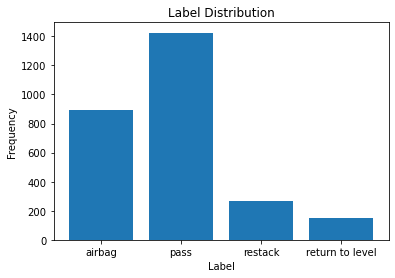

In [38]:
# Re-define labels
labels = metadata_filtered['labels'].tolist()

# Find the unique labels and their frequency in the dataset.
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a bar plot of the label distribution.
plt.bar(unique_labels, label_counts)

# Set the plot title and axis labels.
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")

# Show the plot.
plt.show()

In [39]:
# Actual label counts
label_counts

array([ 892, 1425,  268,  147], dtype=int64)

In [40]:
# Create a metadata df with only images from the Folders of interest    
df = metadata_filtered.copy()

print('Number of images for model training: ', len(df))

Number of images for model training:  2732


In [41]:
# Shuffle the rows of our filtered metadata df
shuffled_df = df.sample(frac=1, random_state=71223)

# After shuffling, split into train and test
# Calculate the split index
split_index = int(len(shuffled_df) * 0.8)

# Split the dataframe into training and test sets
train_df = shuffled_df.iloc[:split_index]
test_df = shuffled_df.iloc[split_index:]

# Check the lengths of train/test
print('Length of train df:', len(train_df))
print('Length of test df:', len(test_df))

Length of train df: 2185
Length of test df: 547


In [42]:
# Generate the data generator
data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Define batch size
batch_size = 32

# Generate data from folders of interest
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory="Photos Upload\\export_20230424_123416",
    x_col='ext',
    y_col='labels',
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical")

# Generate data from folders of interest
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory="Photos Upload\\export_20230424_123416",
    x_col='ext',
    y_col='labels',
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical")

Found 2185 validated image filenames belonging to 4 classes.
Found 547 validated image filenames belonging to 4 classes.


In [43]:
# Assign images and labels from train and test generators
train_images = train_generator[0][0]
train_labels = train_generator[0][1]

test_images = test_generator[0][0]
test_labels = test_generator[0][1]

In [44]:
# Create a Sequential model
classifier = Sequential()

# Add Conv2D layer
classifier.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    input_shape=train_images.shape[1:],
    activation='relu'
))

# Add MaxPooling2D layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Add another Conv2D layer
classifier.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    activation='relu'
))

# Add another MaxPooling2D layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output from Conv2D and MaxPooling2D layers
classifier.add(Flatten())

# Add Dense layer
classifier.add(Dense(units=128, activation='relu'))

# Add final Dense layer for output probabilities
classifier.add(Dense(units=len(train_generator.class_indices), activation='softmax'))

# Compile the model
classifier.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
# Train the model
history = classifier.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=100
)

Epoch 1/100
10/10 [==============================] - 35s 3s/step - loss: 6.0870 - accuracy: 0.4375
Epoch 2/100
10/10 [==============================] - 40s 4s/step - loss: 1.3105 - accuracy: 0.4313
Epoch 3/100
10/10 [==============================] - 50s 5s/step - loss: 1.1826 - accuracy: 0.4281
Epoch 4/100
10/10 [==============================] - 37s 4s/step - loss: 1.1292 - accuracy: 0.4375
Epoch 5/100
10/10 [==============================] - 33s 3s/step - loss: 1.1638 - accuracy: 0.4250
Epoch 6/100
10/10 [==============================] - 31s 3s/step - loss: 1.1003 - accuracy: 0.5094
Epoch 7/100
10/10 [==============================] - 33s 3s/step - loss: 1.0859 - accuracy: 0.5094
Epoch 8/100
10/10 [==============================] - 34s 3s/step - loss: 1.0865 - accuracy: 0.5750
Epoch 9/100
10/10 [==============================] - 35s 3s/step - loss: 1.1067 - accuracy: 0.4906
Epoch 10/100
10/10 [==============================] - 33s 3s/step - loss: 1.0324 - accuracy: 0.5188
Epoch 11/

10/10 [==============================] - 30s 3s/step - loss: 0.9202 - accuracy: 0.6062
Epoch 84/100
10/10 [==============================] - 29s 3s/step - loss: 1.0160 - accuracy: 0.5625
Epoch 85/100
10/10 [==============================] - 31s 3s/step - loss: 0.8815 - accuracy: 0.6313
Epoch 86/100
10/10 [==============================] - 28s 3s/step - loss: 0.8364 - accuracy: 0.6397
Epoch 87/100
10/10 [==============================] - 30s 3s/step - loss: 0.9004 - accuracy: 0.6375
Epoch 88/100
10/10 [==============================] - 32s 3s/step - loss: 0.8874 - accuracy: 0.6281
Epoch 89/100
10/10 [==============================] - 35s 3s/step - loss: 0.9039 - accuracy: 0.6281
Epoch 90/100
10/10 [==============================] - 31s 3s/step - loss: 0.8739 - accuracy: 0.6031
Epoch 91/100
10/10 [==============================] - 31s 3s/step - loss: 0.8456 - accuracy: 0.6531
Epoch 92/100
10/10 [==============================] - 31s 3s/step - loss: 0.8369 - accuracy: 0.6500
Epoch 93/100


In [46]:
# Save model
classifier.save('Capstone_Model1.h5')
print("Model has been saved")

Model has been saved


In [47]:
# Load model
model = load_model('Capstone_Model1.h5')
print("Loaded model from local folder")

Loaded model from local folder


In [48]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 42s 2s/step - loss: 1.3122 - accuracy: 0.5009
Test accuracy: 0.5009140968322754
Test loss: 1.3122375011444092


In [49]:
# Make predictions on the test data
predictions = model.predict(test_images)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = np.argmax(test_labels, axis=1)

# Print some example predictions
for i in range(len(test_images)):
    print("Image", i)
    print("Predicted label:", predicted_labels[i])
    print("True label:", true_labels[i])
    print()

1/1 [==============================] - 0s 308ms/step
Image 0
Predicted label: 0
True label: 0

Image 1
Predicted label: 1
True label: 1

Image 2
Predicted label: 0
True label: 0

Image 3
Predicted label: 0
True label: 2

Image 4
Predicted label: 1
True label: 1

Image 5
Predicted label: 1
True label: 1

Image 6
Predicted label: 1
True label: 1

Image 7
Predicted label: 1
True label: 0

Image 8
Predicted label: 1
True label: 0

Image 9
Predicted label: 1
True label: 2

Image 10
Predicted label: 1
True label: 1

Image 11
Predicted label: 1
True label: 1

Image 12
Predicted label: 1
True label: 1

Image 13
Predicted label: 1
True label: 0

Image 14
Predicted label: 0
True label: 2

Image 15
Predicted label: 1
True label: 0

Image 16
Predicted label: 1
True label: 0

Image 17
Predicted label: 1
True label: 0

Image 18
Predicted label: 1
True label: 3

Image 19
Predicted label: 1
True label: 1

Image 20
Predicted label: 1
True label: 1

Image 21
Predicted label: 0
True label: 0

Image 22
Pr

**AIRBAG ONLY PREDICTIONS (BINARY)**
- Any entries with airbag in Category 1, 2, or 3 are labeled as 1, rest are 0

In [50]:
# Create a new column that is equal to 1 if any of the specified columns contain 'airbag'
airbags = df.loc[:,'CATEGORY 1':'CATEGORY 3'].apply(lambda x: 'pass' if 'airbag' in x.values else 'fail', axis=1) #1 and 0 are strings
df['airbag'] = airbags

df

,id,manifestid,documentid,Full,uploaddatetimejsonmetadata,Folder,File,LABEL,SIGN OUT,ALLIGATOR,...,is_blurry,is_dark,is_angle,is_glare,is_outside,is_zoom,is_duplicate,ext,labels,airbag
0,180426,43417541,83328644,True,4/7/2023 7:25,328,644-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,328\644-0.jpg,pass,fail
1,180429,43418071,83328656,False,4/7/2023 7:26,328,656-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,328\656-0.jpg,pass,fail
2,180421,43416911,83328720,False,4/7/2023 7:24,328,720-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,328\720-0.jpg,pass,fail
4,180422,43416961,83328780,True,4/7/2023 7:24,328,780-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,328\780-0.jpg,pass,fail
6,180424,43416961,83328782,False,4/7/2023 7:24,328,782-0.jpg,Vogt,4/29,False,...,0,0,0,0,0,0,0,328\782-0.jpg,airbag,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,185401,43446001,83438679,False,4/13/2023 18:04,438,679-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,438\679-0.jpg,airbag,pass
4996,185405,43457501,83438681,False,4/13/2023 18:07,438,681-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,438\681-0.jpg,airbag,pass
4997,185399,43431131,83438683,False,4/13/2023 18:01,438,683-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,438\683-0.jpg,pass,fail
4998,185403,43449031,83438750,False,4/13/2023 18:06,438,750-0.jpg,Nida,6/30,False,...,0,0,0,0,0,0,0,438\750-0.jpg,pass,fail


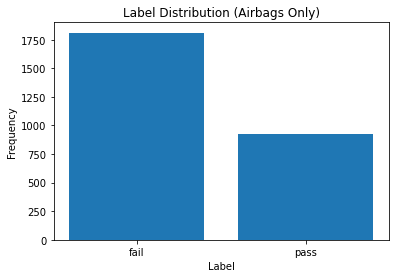

In [51]:
# Re-define labels
labels_airbags = df['airbag'].tolist()

# Find the unique labels and their frequency in the dataset.
unique_labels_airbags, label_counts_airbags = np.unique(labels_airbags, return_counts=True)

# Create a bar plot of the label distribution.
plt.bar(unique_labels_airbags, label_counts_airbags)

# Set the plot title and axis labels.
plt.title("Label Distribution (Airbags Only)")
plt.xlabel("Label")
plt.ylabel("Frequency")

# Show the plot.
plt.show()

In [52]:
label_counts_airbags

array([1811,  921], dtype=int64)

In [53]:
# Shuffle the rows of our filtered metadata df
shuffled_df_airbags = df.sample(frac=1, random_state=71223)

# Split the dataframe into training and test sets
train_df_airbags = shuffled_df_airbags.iloc[:split_index]
test_df_airbags = shuffled_df_airbags.iloc[split_index:]

# Check the lengths of train/test
print('Length of train df:', len(train_df))
print('Length of test df:', len(test_df))

Length of train df: 2185
Length of test df: 547


In [54]:
# Generate data from folders of interest
train_generator_airbags = data_generator.flow_from_dataframe(
    dataframe=train_df_airbags,
    directory="Photos Upload\\export_20230424_123416",
    x_col='ext',
    y_col='airbag',
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="binary")

# Generate data from folders of interest
test_generator_airbags = data_generator.flow_from_dataframe(
    dataframe=test_df_airbags,
    directory="Photos Upload\\export_20230424_123416",
    x_col='ext',
    y_col='airbag',
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="binary")

Found 2185 validated image filenames belonging to 2 classes.
Found 547 validated image filenames belonging to 2 classes.


In [55]:
# Assign images and labels from train and test generators
train_images_airbags = train_generator_airbags[0][0]
train_labels_airbags = train_generator_airbags[0][1]

test_images_airbags = test_generator_airbags[0][0]
test_labels_airbags = test_generator_airbags[0][1]

In [56]:
# Create a Sequential model
classifier_airbags = Sequential()

# Add Conv2D layer
classifier_airbags.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    input_shape=train_images_airbags.shape[1:],
    activation='relu'
))

# Add MaxPooling2D layer
classifier_airbags.add(MaxPooling2D(pool_size=(2,2)))

# Add another Conv2D layer
classifier_airbags.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    activation='relu'
))

# Add another MaxPooling2D layer
classifier_airbags.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output from Conv2D and MaxPooling2D layers
classifier_airbags.add(Flatten())

# Add Dense layer
classifier_airbags.add(Dense(units=128, activation='relu'))

# Add final Dense layer for output probabilities
classifier_airbags.add(Dense(1, activation='sigmoid'))

# Compile the model
classifier_airbags.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [57]:
# Train the model
history_airbags = classifier_airbags.fit(
    train_generator_airbags,
    steps_per_epoch=10,
    epochs=100
)

Epoch 1/100
10/10 [==============================] - 30s 3s/step - loss: 4.7609 - accuracy: 0.5152
Epoch 2/100
10/10 [==============================] - 30s 3s/step - loss: 0.6227 - accuracy: 0.6938
Epoch 3/100
10/10 [==============================] - 30s 3s/step - loss: 0.6495 - accuracy: 0.6500
Epoch 4/100
10/10 [==============================] - 30s 3s/step - loss: 0.6434 - accuracy: 0.6687
Epoch 5/100
10/10 [==============================] - 27s 3s/step - loss: 0.6551 - accuracy: 0.6431
Epoch 6/100
10/10 [==============================] - 30s 3s/step - loss: 0.6531 - accuracy: 0.6438
Epoch 7/100
10/10 [==============================] - 29s 3s/step - loss: 0.6162 - accuracy: 0.7063
Epoch 8/100
10/10 [==============================] - 29s 3s/step - loss: 0.6318 - accuracy: 0.6812
Epoch 9/100
10/10 [==============================] - 30s 3s/step - loss: 0.6537 - accuracy: 0.6469
Epoch 10/100
10/10 [==============================] - 30s 3s/step - loss: 0.6403 - accuracy: 0.6750
Epoch 11/

10/10 [==============================] - 31s 3s/step - loss: 0.5874 - accuracy: 0.7063
Epoch 84/100
10/10 [==============================] - 31s 3s/step - loss: 0.5972 - accuracy: 0.6906
Epoch 85/100
10/10 [==============================] - 31s 3s/step - loss: 0.5435 - accuracy: 0.7563
Epoch 86/100
10/10 [==============================] - 31s 3s/step - loss: 0.5717 - accuracy: 0.7250
Epoch 87/100
10/10 [==============================] - 32s 3s/step - loss: 0.5623 - accuracy: 0.7312
Epoch 88/100
10/10 [==============================] - 32s 3s/step - loss: 0.5166 - accuracy: 0.7531
Epoch 89/100
10/10 [==============================] - 31s 3s/step - loss: 0.5081 - accuracy: 0.7594
Epoch 90/100
10/10 [==============================] - 36s 4s/step - loss: 0.5742 - accuracy: 0.6875
Epoch 91/100
10/10 [==============================] - 33s 3s/step - loss: 0.5489 - accuracy: 0.7281
Epoch 92/100
10/10 [==============================] - 31s 3s/step - loss: 0.5037 - accuracy: 0.7312
Epoch 93/100


In [58]:
# Save model
classifier_airbags.save('Capstone_Airbags_Model1.h5')
print("Model has been saved")

Model has been saved


In [59]:
# Load model
model_airbags = load_model('Capstone_Airbags_Model1.h5')
print("Loaded model from local folder")

Loaded model from local folder


In [60]:
# Evaluate the model on the test dataset
test_loss_airbags, test_acc_airbags = model_airbags.evaluate(test_generator_airbags, steps=len(test_generator_airbags))

print('Test accuracy:', test_acc_airbags)
print('Test loss:', test_loss_airbags)

18/18 [==============================] - 46s 3s/step - loss: 0.6484 - accuracy: 0.6380
Test accuracy: 0.6380255818367004
Test loss: 0.6484076976776123


In [61]:
# Calculate predictions
predictions_airbags = model_airbags.predict(test_generator_airbags)

# View predictions
predictions_airbags

18/18 [==============================] - 45s 3s/step


array([[0.13833962],
       [0.56181747],
       [0.31098002],
       [0.5739785 ],
       [0.5348909 ],
       [0.08211317],
       [0.3258649 ],
       [0.34892464],
       [0.58200127],
       [0.5133384 ],
       [0.6046736 ],
       [0.25708967],
       [0.3375231 ],
       [0.5444671 ],
       [0.4638976 ],
       [0.21362506],
       [0.518648  ],
       [0.5154407 ],
       [0.30440962],
       [0.15407877],
       [0.48508984],
       [0.42951262],
       [0.18040884],
       [0.49082777],
       [0.28082037],
       [0.5363917 ],
       [0.63358396],
       [0.11315013],
       [0.03448761],
       [0.42658073],
       [0.5502557 ],
       [0.3788007 ],
       [0.15139832],
       [0.20392764],
       [0.40295127],
       [0.57683074],
       [0.19279079],
       [0.46148404],
       [0.25389838],
       [0.41307834],
       [0.51844096],
       [0.48089686],
       [0.5548686 ],
       [0.5723281 ],
       [0.3382084 ],
       [0.06313431],
       [0.21989988],
       [0.427

In [62]:
predictions_airbags.mean()

0.41368043

In [63]:
# Manually define threshold for binary predictions
threshold = 0.4137
binary_predictions_airbags = [1 if prediction > threshold else 0 for prediction in predictions_airbags]
binary_predictions_airbags

[0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,


In [64]:
# Compute precision, recall, and F1-score
precision_airbags = precision_score(test_generator_airbags.classes, binary_predictions_airbags)
recall_airbags = recall_score(test_generator_airbags.classes, binary_predictions_airbags)
f1_airbags = f1_score(test_generator_airbags.classes, binary_predictions_airbags)

# Print the metrics
print("Loss: {:.4f}".format(test_loss_airbags))
print("Accuracy: {:.4f}".format(test_acc_airbags))
print("Precision: {:.4f}".format(precision_airbags))
print("Recall: {:.4f}".format(recall_airbags))
print("F1-Score: {:.4f}".format(f1_airbags))

Loss: 0.6484
Accuracy: 0.6380
Precision: 0.3554
Recall: 0.5312
F1-Score: 0.4259


**3RD MODEL WITH NO DUNNAGE AND STRAP CATEGORIES**

In [51]:
# Create a copy of df
df2 = df.copy()

# REPLACING THE DUNNAGE AND STRAP LABELS WITH SECONDARY LABELS, TERTIARY LABELS, OR PASSING LABELS

# Filter rows where 'labels' column is either 'dunnage' or 'strap'
mask = (df2['labels'] == 'dunnage') | (df2['labels'] == 'strap')

# Replace values in 'labels' column with corresponding values from 'CATEGORY 2' column
df2.loc[mask, 'labels'] = df2.loc[mask, 'CATEGORY 2']

# Replace any new NAs with passing label
df2['labels'] = df2['labels'].fillna('pass')

# Define these labels
labels2 = df2['labels'].tolist()

# Make these labels case-insensitive
labels2 = np.char.lower(labels2)

# Add labels back to the df
df2['labels'] = labels2

# Now take any remaining dunnage/strap labels and replace them with the 'CATEGORY 3' column (aka tertiary label)
# Filter rows where 'labels' column is either 'dunnage' or 'strap'
mask2 = (df2['labels'] == 'dunnage') | (df2['labels'] == 'strap')

# Replace values in 'labels' column with corresponding values from 'CATEGORY 2' column
df2.loc[mask2, 'labels'] = df2.loc[mask2, 'CATEGORY 3']

# Replace any new NAs with passing label
df2['labels'] = df2['labels'].fillna('pass')

# Define these labels
labels3 = df2['labels'].tolist()

# Make these labels case-insensitive
labels3 = np.char.lower(labels3)

# Add labels back to the df
df2['labels'] = labels3

# Confirm that we now have only the labels we want (should be pass, airbag, return to level, and restack)
unique_values = df2['labels'].unique()
print(unique_values)

['pass' 'airbag' 'return to level' 'restack']


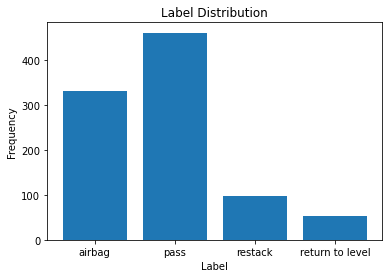

In [52]:
# Find the unique labels and their frequency in the dataset.
unique_labels3, label_counts3 = np.unique(labels3, return_counts=True)

# Create a bar plot of the label distribution.
plt.bar(unique_labels3, label_counts3)

# Set the plot title and axis labels.
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")

# Show the plot.
plt.show()

In [53]:
label_counts3

array([331, 460,  98,  53], dtype=int64)

In [54]:
# Shuffle the rows of our filtered metadata df
shuffled_df2 = df2.sample(frac=1, random_state=51623)

# After shuffling, split into train and test
# Calculate the split index
split_index2 = int(len(shuffled_df2) * 0.8)

# Split the dataframe into training and test sets
train_df2 = shuffled_df2.iloc[:split_index2]
test_df2 = shuffled_df2.iloc[split_index2:]

# Check the lengths of train/test
print('Length of train df:', len(train_df2))
print('Length of test df:', len(test_df2))

Length of train df: 753
Length of test df: 189


In [55]:
# Generate new data from folders of interest
train_generator2 = data_generator.flow_from_dataframe(
    dataframe=train_df2,
    directory="Photos Upload\\export_20230424_123416",
    x_col='ext',
    y_col='labels',
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical")

# Generate data from folders of interest
test_generator2 = data_generator.flow_from_dataframe(
    dataframe=test_df2,
    directory="Photos Upload\\export_20230424_123416",
    x_col='ext',
    y_col='labels',
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical")

Found 753 validated image filenames belonging to 4 classes.
Found 189 validated image filenames belonging to 4 classes.


In [56]:
# Assign images and labels from train and test generators
train_images2 = train_generator2[0][0]
train_labels2 = train_generator2[0][1]

test_images2 = test_generator2[0][0]
test_labels2 = test_generator2[0][1]

In [57]:
# Create a Sequential model
classifier2 = Sequential()

# Add Conv2D layer
classifier2.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    input_shape=train_images2.shape[1:],
    activation='relu'
))

# Add MaxPooling2D layer
classifier2.add(MaxPooling2D(pool_size=(2,2)))

# Add another Conv2D layer
classifier2.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    activation='relu'
))

# Add another MaxPooling2D layer
classifier2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output from Conv2D and MaxPooling2D layers
classifier2.add(Flatten())

# Add Dense layer
classifier2.add(Dense(units=128, activation='relu'))

# Add final Dense layer for output probabilities
classifier2.add(Dense(units=len(train_generator2.class_indices), activation='softmax'))

# Compile the model
classifier2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
# Train the model
history2 = classifier2.fit(
    train_generator2,
    steps_per_epoch=3,
    epochs=10
)

Epoch 1/10
3/3 [==============================] - 10s 3s/step - loss: 10.8310 - accuracy: 0.4583
Epoch 2/10
3/3 [==============================] - 14s 5s/step - loss: 10.5039 - accuracy: 0.3229
Epoch 3/10
3/3 [==============================] - 12s 4s/step - loss: 7.9905 - accuracy: 0.3333
Epoch 4/10
3/3 [==============================] - 12s 4s/step - loss: 1.2250 - accuracy: 0.5417
Epoch 5/10
3/3 [==============================] - 11s 4s/step - loss: 1.3341 - accuracy: 0.3958
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 1.3776 - accuracy: 0.2917
Epoch 7/10
3/3 [==============================] - 9s 3s/step - loss: 1.3743 - accuracy: 0.3333
Epoch 8/10
3/3 [==============================] - 10s 3s/step - loss: 1.3582 - accuracy: 0.3646
Epoch 9/10
3/3 [==============================] - 9s 3s/step - loss: 1.2133 - accuracy: 0.4583
Epoch 10/10
3/3 [==============================] - 8s 3s/step - loss: 1.1317 - accuracy: 0.4815


In [59]:
# Save model
classifier2.save('Capstone_Model2.h5')
print("Model has been saved")

Model has been saved


In [60]:
# Load model
model2 = load_model('Capstone_Model2.h5')
print("Loaded model from local folder")

Loaded model from local folder


In [61]:
# Evaluate the model on the test dataset
test_loss2, test_acc2 = model2.evaluate(test_generator2, steps=len(test_generator2))

print('Test accuracy:', test_acc2)
print('Test loss:', test_loss2)

6/6 [==============================] - 16s 3s/step - loss: 1.2266 - accuracy: 0.3333
Test accuracy: 0.3333333432674408
Test loss: 1.2265820503234863


In [62]:
# Make predictions on the test data
predictions2 = model2.predict(test_images2)

# Get the predicted class labels
predicted_labels2 = np.argmax(predictions2, axis=1)

# Get the true class labels
true_labels2 = np.argmax(test_labels2, axis=1)

# Print some example predictions
for i in range(len(test_images2)):
    print("Image", i)
    print("Predicted label:", predicted_labels2[i])
    print("True label:", true_labels2[i])
    print()

1/1 [==============================] - 0s 341ms/step
Image 0
Predicted label: 0
True label: 1

Image 1
Predicted label: 0
True label: 0

Image 2
Predicted label: 0
True label: 1

Image 3
Predicted label: 0
True label: 1

Image 4
Predicted label: 0
True label: 1

Image 5
Predicted label: 0
True label: 0

Image 6
Predicted label: 0
True label: 1

Image 7
Predicted label: 0
True label: 1

Image 8
Predicted label: 0
True label: 0

Image 9
Predicted label: 0
True label: 0

Image 10
Predicted label: 0
True label: 2

Image 11
Predicted label: 0
True label: 1

Image 12
Predicted label: 0
True label: 0

Image 13
Predicted label: 0
True label: 0

Image 14
Predicted label: 0
True label: 1

Image 15
Predicted label: 0
True label: 2

Image 16
Predicted label: 0
True label: 0

Image 17
Predicted label: 0
True label: 1

Image 18
Predicted label: 0
True label: 1

Image 19
Predicted label: 0
True label: 1

Image 20
Predicted label: 0
True label: 2

Image 21
Predicted label: 0
True label: 3

Image 22
Pr